#### **EfficientNET Model**

#### **Load the dataset**

In [ ]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/

!kaggle datasets download -d msambare/fer2013

!unzip /content/fer2013.zip -d /content/

from google.colab import drive
drive.mount('/content/drive')

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  
  inflating: /content/train/sad/Training_65508578.jpg  

#### **Libraries**

In [34]:
import os
import cv2
import json
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
plt.style.use('default')

from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D



#### **Set random seed**

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### **Defining the paths to your train and test directories**

In [ ]:
train_data_path = '/content/train/'
test_data_path = '/content/test/'

# List folders in the train and test directories
train_folders = os.listdir(train_data_path )
test_folders = os.listdir(test_data_path)

print("Folders in the train directory:")
print(train_folders)

print("\nFolders in the test directory:")
print(test_folders)

Folders in the train directory:
['neutral', 'sad', 'disgust', 'angry', 'happy', 'surprise', 'fear']

Folders in the test directory:
['neutral', 'sad', 'disgust', 'angry', 'happy', 'surprise', 'fear']


#### **Data Preprocessing and Augmentation for Emotion Detection**

In [ ]:
# 1. Data Preprocessing
img_shape = 224
batch_size = 32

# Data Augmentation for training data

train_preprocessor = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,          # Increase rotation range
    zoom_range=0.3,             # Higher zoom range
    width_shift_range=0.2,      # Increased shift range
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],  # Brightness adjustments
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


# Preprocessing for test data
test_preprocessor = ImageDataGenerator(rescale=1/255.0)

# Load training data (80% of the original training data)
train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    batch_size=batch_size,
    shuffle=True,
    subset='training'  # Use only the training data
)

# Load validation data (20% of the original training data)
validation_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    batch_size=batch_size,
    shuffle=True,
    subset='validation'  # Use only the validation data
)

# Load test data (completely separate test set)
test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    batch_size=batch_size,
    shuffle=False
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#### **Model definition**

In [ ]:
base_model = EfficientNetB0(input_shape=(img_shape, img_shape, 3), include_top=False, weights="imagenet")

# Unfreeze layers up to the first 20 for fine-tuning
for layer in base_model.layers[:20]:
    layer.trainable = True

# Build the full model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())

# Add Dense layer with L2 regularization
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(Dropout(0.5))  # Increased Dropout to prevent overfitting
model.add(Dense(7, activation='softmax'))  # Assuming 7 classes



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### **Compile the model**

In [ ]:
# Compile the model with the same optimizer and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Callbacks
checkpoint = ModelCheckpoint('efficientnet_best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)


#### **Training EfficientNETB0 Model**

In [ ]:
history = model.fit(
    train_data,
    validation_data=validation_data,  # Use validation_data instead of test_data
    epochs=100,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.2442 - loss: 2.8127
Epoch 1: val_accuracy improved from -inf to 0.32085, saving model to efficientnet_best_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 467s 535ms/step - accuracy: 0.2443 - loss: 2.8123 - val_accuracy: 0.3209 - val_loss: 2.1252 - learning_rate: 1.0000e-04
Epoch 2/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.3873 - loss: 2.0274
Epoch 2: val_accuracy improved from 0.32085 to 0.48859, saving model to efficientnet_best_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 330s 456ms/step - accuracy: 0.3874 - loss: 2.0273 - val_accuracy: 0.4886 - val_loss: 1.7476 - learning_rate: 1.0000e-04
Epoch 3/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.4662 - loss: 1.8224
Epoch 3: val_accuracy improved from 0.48859 to 0.53440, saving model to efficientnet_best_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 346s 478ms/step - accuracy: 0.4662 - loss: 1.8224 - val_accuracy: 0.5344 - val_loss: 1.6216 - learning_rate: 1.0000

#### **Plotting Training and Validation Accuracy and Loss Over Epochs**

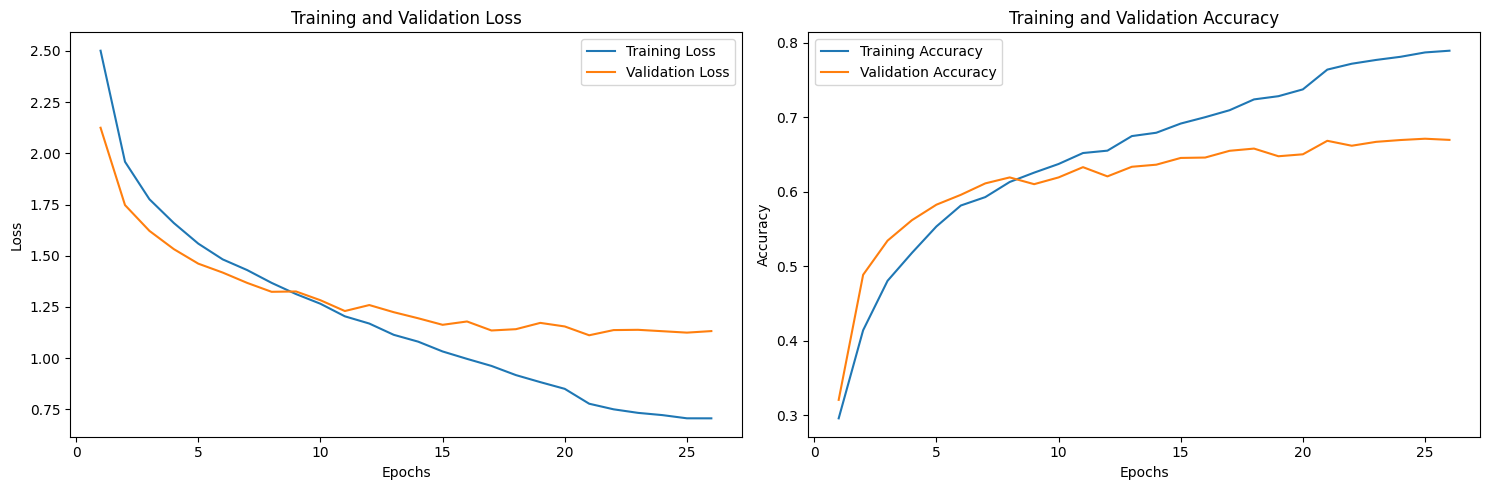

In [ ]:
history = history  # Use the history object from the EfficientNetB0 model

# Get the values for accuracy, loss, and validation metrics
epochs = range(1, len(history.history['accuracy']) + 1)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy and loss
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


#### **Evaluating Performance on Test Data**

In [ ]:
# Evaluate the loaded model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

# Print the evaluation results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.6439 - loss: 1.1542
Test Accuracy: 0.6826
Test Loss: 1.0643


#### **Confusion Matrix**

In [36]:

# Predict labels for the test data
steps = int(np.ceil(test_data.samples / test_data.batch_size))  # Ensure the full test set is predicted
y_pred = np.argmax(model.predict(test_data, steps=steps), axis=1)

# True labels from the test data
y_true = test_data.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Class labels for confusion matrix
class_labels = list(test_data.class_indices.keys())

# Create Plotly heatmap for confusion matrix
fig = ff.create_annotated_heatmap(cm, x=class_labels, y=class_labels, colorscale='Viridis')

# Update heatmap layout
fig.update_layout(
    title="Confusion Matrix for EfficientNetB0 Model",
    xaxis_title="Predicted Label",
    yaxis_title="True Label"
)

# Display the heatmap
fig.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step


#### **Comparison of Train, Validation, and Test Accuracy at Best Epoch**

In [ ]:
# Get the history from the model
history_dict = history.history

# Find the best epoch based on validation accuracy
best_epoch = np.argmax(history_dict['val_accuracy']) + 1

# Extract training accuracy, validation accuracy at the best epoch
best_training_acc = history_dict['accuracy'][best_epoch - 1]
best_val_acc = history_dict['val_accuracy'][best_epoch - 1]

# Evaluate the model on the test data to get test accuracy
test_loss, best_test_acc = model.evaluate(test_data)

# Print the output
print(f"Best Epoch: {best_epoch}")
print(f"Training Accuracy: {best_training_acc}")
print(f"Validation Accuracy: {best_val_acc}")
print(f"Test Accuracy: {best_test_acc}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6439 - loss: 1.1542
Best Epoch: 25
Training Accuracy: 0.7868773937225342
Validation Accuracy: 0.6711374521255493
Test Accuracy: 0.6826413869857788


#### **Saving the Accuracies**

In [ ]:
# Step 1: Identify the best epoch based on validation loss
best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1

# Step 2: Retrieve key metrics (accuracy and loss) with rounding
best_train_accuracy = round(history.history['accuracy'][best_epoch - 1], 2)
best_val_accuracy = round(history.history['val_accuracy'][best_epoch - 1], 2)
best_train_loss = round(history.history['loss'][best_epoch - 1], 2)
best_val_loss = round(history.history['val_loss'][best_epoch - 1], 2)

# Step 3: Evaluate the current in-memory model on test data (no need to load it)
test_loss, test_accuracy = model.evaluate(test_data)
test_loss = round(test_loss, 2)
test_accuracy = round(test_accuracy, 2)

# Step 4: Collect all the metrics in a DataFrame with updated EfficientNetB0-related names
metrics_df = pd.DataFrame({
    'Metric': ['EfficientNetB0 Best Epoch', 'EfficientNetB0 Train Accuracy', 'EfficientNetB0 Validation Accuracy', 'EfficientNetB0 Train Loss', 'EfficientNetB0 Validation Loss', 'EfficientNetB0 Test Accuracy', 'EfficientNetB0 Test Loss'],
    'Value': [best_epoch, best_train_accuracy, best_val_accuracy, best_train_loss, best_val_loss, test_accuracy, test_loss]
})

# Step 5: Save the DataFrame and model to Google Drive or any local directory
save_path = '/content/drive/MyDrive/Emotion_Detection/EfficientNETB0_Model/EfficientNET_Output'
os.makedirs(save_path, exist_ok=True)

# Save the metrics as a CSV file
metrics_save_path = os.path.join(save_path, 'efficientnet_model_metrics.csv')
metrics_df.to_csv(metrics_save_path, index=False)

# Save the current in-memory model (no need to load the model again)
model_save_path = os.path.join(save_path, 'EfficientNetB0_model.keras')
model.save(model_save_path)

print(f"Best model and metrics successfully saved to {save_path}")

# Display the DataFrame with metrics
metrics_df


225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6439 - loss: 1.1542
Best model and metrics successfully saved to /content/drive/MyDrive/Emotion_Detection/EfficientNETB0_Model/EfficientNET_Output


,Metric,Value
0,EfficientNetB0 Best Epoch,21.00
1,EfficientNetB0 Train Accuracy,0.76
2,EfficientNetB0 Validation Accuracy,0.67
3,EfficientNetB0 Train Loss,0.78
4,EfficientNetB0 Validation Loss,1.11
5,EfficientNetB0 Test Accuracy,0.68
6,EfficientNetB0 Test Loss,1.06


#### **Preprocess the Input Data**

In [ ]:
# Function to load and preprocess an image for EfficientNetB0 using OpenCV
def load_and_preprocess_image_cv(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img_array = np.expand_dims(img, axis=0)
    img_array = img_array / 255.0
    return img_array

# Function to predict emotion for a single image using EfficientNetB0
def predict_emotion_cv(img_path, model):
    img_array = load_and_preprocess_image_cv(img_path)
    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction, axis=1)
    return predicted_label[0]


#### **Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


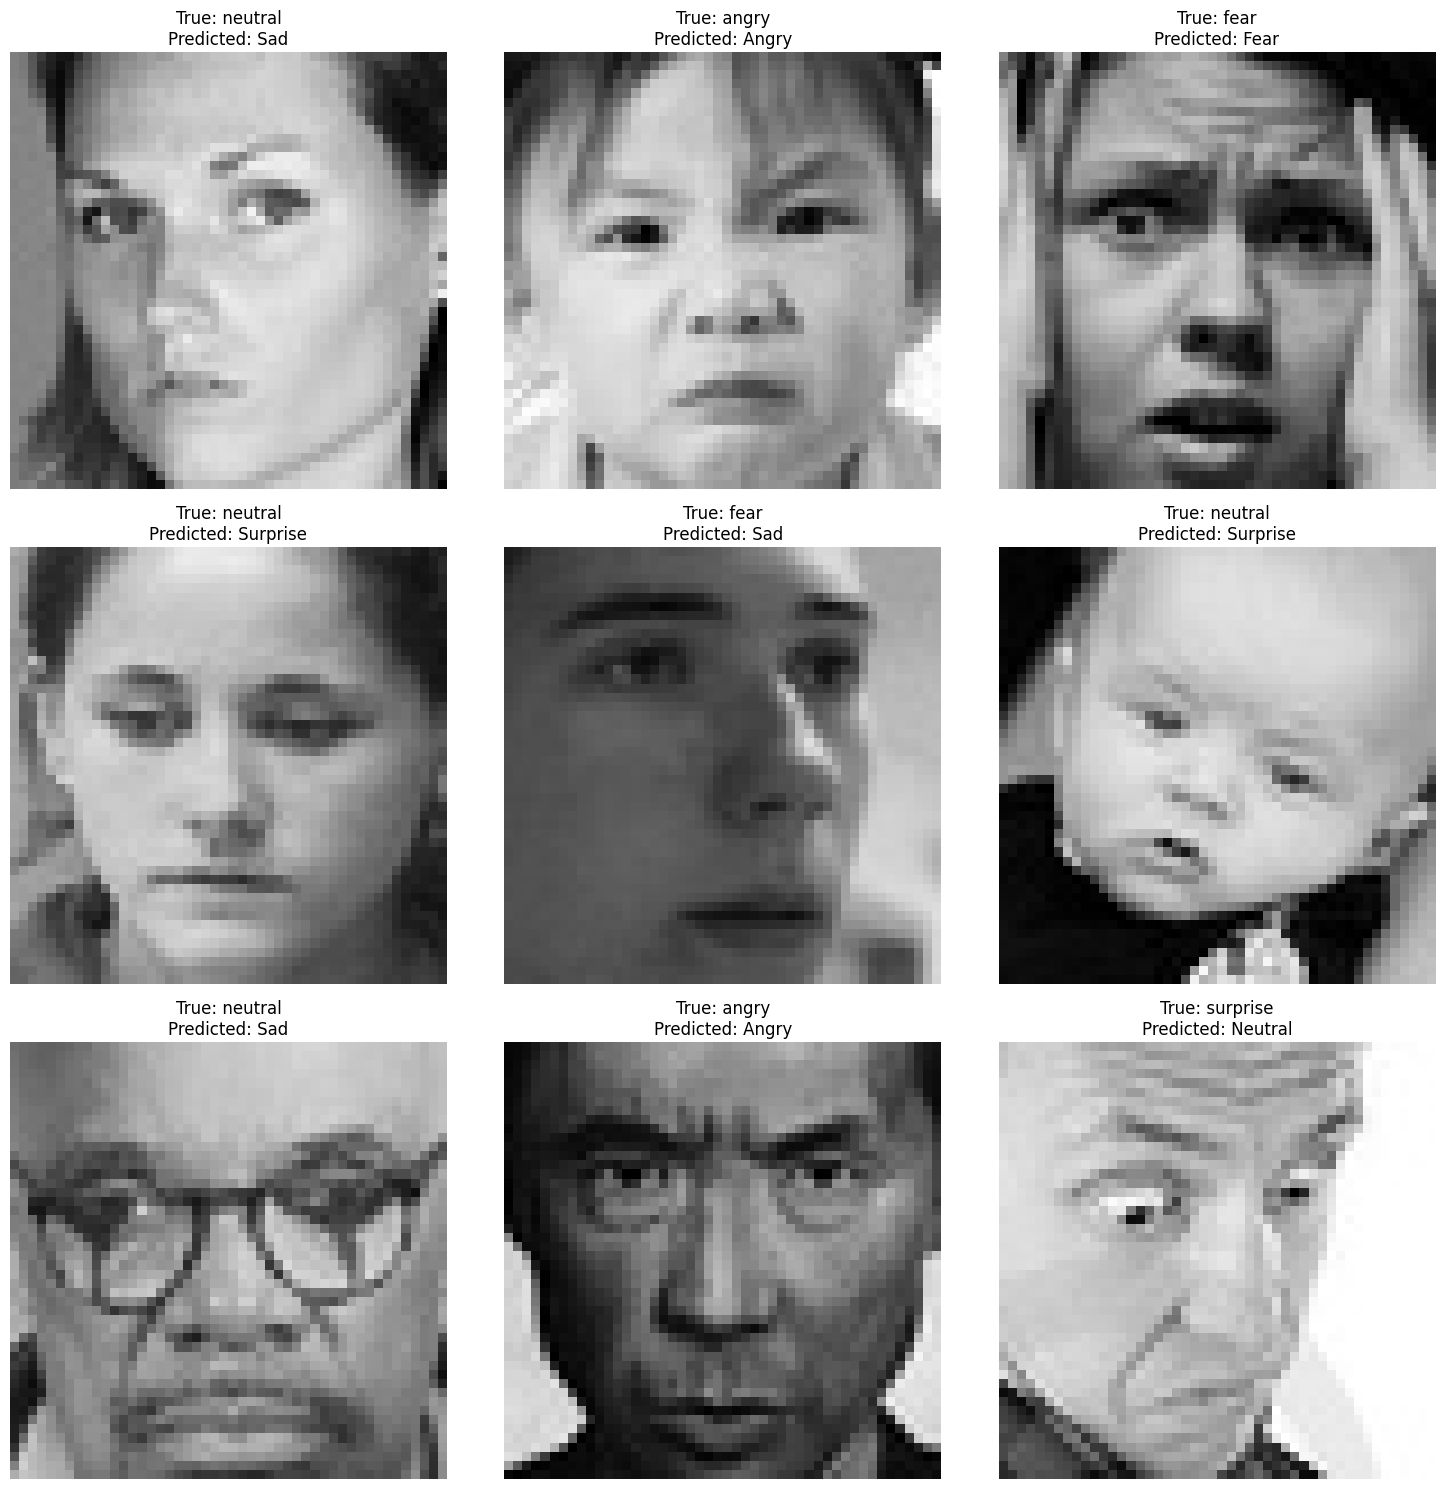

In [ ]:
class_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Function to display images with predicted and true labels using OpenCV and EfficientNetB0
def display_predictions_cv(images_dir, model, num_images=9):
    image_files = [os.path.join(root, file)
                   for root, _, files in os.walk(images_dir)
                   for file in files if file.endswith(('.png', '.jpg', '.jpeg'))]

    # Select a subset of images to display
    selected_images = np.random.choice(image_files, num_images, replace=False)

    # Create a plot to display the images
    plt.figure(figsize=(15, 15))

    for i, img_path in enumerate(selected_images):
        img = cv2.imread(img_path)  # Load image using OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        true_label = img_path.split(os.path.sep)[-2]

        # Predict the emotion using the EfficientNetB0 model
        predicted_label = predict_emotion_cv(img_path, model)
        predicted_label_name = class_labels[predicted_label]
        # Display the image with true and predicted labels
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on the test images using OpenCV and EfficientNetB0
test_images_dir = '/content/drive/MyDrive/fer2013/test_images'
display_predictions_cv(test_images_dir, model, num_images=9)
